In [1]:
import pandas as pd 
import random
import math
import time
from sklearn.linear_model import LinearRegression, BayesianRidge
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, mean_absolute_error
import datetime
import operator 
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from autograd.misc.flatten import flatten_func
from autograd import grad
from autograd import hessian
from autograd import numpy as np
import math
import copy
# this is needed to compensate for %matplotl+ib notebook's tendancy to blow up images when plotted inline
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%matplotlib notebook
%load_ext autoreload
%autoreload 2
print("Success!")

Success!


In [2]:
confirmed_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
deaths_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv')
recoveries_df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv')
latest_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports/06-02-2020.csv')
us_medical_data = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_daily_reports_us/06-02-2020.csv')

In [3]:
# print the column name of the confirmed numbers
cols = confirmed_df.keys()
# we focus on the US region
confirmed_us = confirmed_df.loc[confirmed_df['Country/Region'] == 'US', :]
# print the deathes in US
deaths_us = deaths_df.loc[deaths_df['Country/Region'] == 'US', :]
# print the recovered people in US
recover_us = recoveries_df.loc[recoveries_df['Country/Region'] == 'US', :]
confirmed = confirmed_us.loc[:, cols[4]:cols[-1]]
deaths = deaths_us.loc[:, cols[4]:cols[-1]]
recover = recover_us.loc[:, cols[4]:cols[-1]]

In [4]:
dates = confirmed.keys()
us_cases = []
us_deaths = [] 
us_recoveries = [] 
for i in dates:
    us_cases.append(confirmed_df[confirmed_df['Country/Region']=='US'][i].sum())
    
    us_deaths.append(deaths_df[deaths_df['Country/Region']=='US'][i].sum())
    
    us_recoveries.append(recoveries_df[recoveries_df['Country/Region']=='US'][i].sum())
def daily_increase(data):
    d = [] 
    for i in range(len(data)):
        if i == 0:
            d.append(data[0])
        else:
            d.append(data[i]-data[i-1])
    return d 

us_daily_increase = daily_increase(us_cases)
us_daily_death = daily_increase(us_deaths)
us_daily_recovery = daily_increase(us_recoveries)

days_since_1_22 = np.array([i for i in range(len(dates))]).reshape(-1, 1)

In [5]:
# future forecasting
days_in_future = 10
future_forcast = np.array([i for i in range(len(dates)+days_in_future)]).reshape(-1, 1)
adjusted_dates = future_forcast[:-10]

In [6]:
start = '1/22/2020'
start_date = datetime.datetime.strptime(start, '%m/%d/%Y')
future_forcast_dates = []
for i in range(len(future_forcast)):
    future_forcast_dates.append((start_date + datetime.timedelta(days=i)).strftime('%m/%d/%Y'))

In [7]:
X_train_confirmed, X_test_confirmed, y_train_confirmed, y_test_confirmed = train_test_split(days_since_1_22, us_cases, test_size=0.3, shuffle=False) 

Linear regression part

In [8]:
reg = LinearRegression().fit(X_train_confirmed, y_train_confirmed)
# do the prediction about the 
linear_test_pred = reg.predict(X_test_confirmed)
linear_train_pred = reg.predict(X_train_confirmed)
linear_future_pred = reg.predict(future_forcast)

polynomial regression

In [9]:
# transform our data for polynomial regression
poly = PolynomialFeatures(degree = 3)
poly_X_train_confirmed = poly.fit_transform(X_train_confirmed)
poly_X_test_confirmed = poly.fit_transform(X_test_confirmed)
poly_future_forcast = poly.fit_transform(future_forcast)

# polynomial regression
poly_model = LinearRegression(normalize=True, fit_intercept=False)
poly_model.fit(poly_X_train_confirmed, y_train_confirmed)
poly_train_pred = poly_model.predict(poly_X_train_confirmed)
poly_test_pred = poly_model.predict(poly_X_test_confirmed)
poly_future_pred = poly_model.predict(poly_future_forcast)

SVM prediction

In [10]:
svm_model = SVR(shrinking=True, kernel='poly', gamma=0.01, epsilon=0.1, degree=4, C=0.01)
svm_model.fit(X_train_confirmed, y_train_confirmed)
svm_test_pred = svm_model.predict(X_test_confirmed)
svm_train_pred = svm_model.predict(X_train_confirmed)
svm_future_pred = svm_model.predict(future_forcast)

neural network

In [11]:
import torch
import torch.nn.functional as F

class Neural_Network(torch.nn.Module):
    
    def __init__(self, n_feature, n_hidden, n_output):
        super(Neural_Network, self).__init__()
        self.hidden_layer1 = torch.nn.Linear(n_feature, n_hidden)
        #self.hidden_layer2 = torch.nn.Linear(n_hidden, int(n_feature/2))
        self.predict_layer = torch.nn.Linear(n_hidden, n_output)

    def forward(self, x):
        hidden_result1 = self.hidden_layer1(x)
        relu_result1 = F.relu(hidden_result1)
        #hidden_result2 = self.hidden_layer2(relu_result1)
        #relu_result2 = F.relu(hidden_result2)
        predict_result = self.predict_layer(relu_result1)
        return predict_result

In [12]:
# parameters setting
TRAIN_TIMES = 2000
INPUT_FEATURE_DIM = 1
OUTPUT_FEATURE_DIM = 1
NEURON_NUM = 64
LEARNING_RATE = 0.5

In [13]:
#transform all the data into tensor
nn_train_x = torch.unsqueeze(torch.Tensor(X_train_confirmed.reshape(-1)), dim=1)
nn_train_y = torch.unsqueeze(torch.Tensor(y_train_confirmed), dim=1)
nn_test_x = torch.unsqueeze(torch.Tensor(X_test_confirmed.reshape(-1)), dim=1)
nn_test_y = torch.unsqueeze(torch.Tensor(y_test_confirmed), dim=1)
nn_future_forcast = torch.unsqueeze(torch.Tensor(future_forcast.reshape(-1)), dim=1)

In [14]:
nn_model = Neural_Network(n_feature=INPUT_FEATURE_DIM, n_hidden=NEURON_NUM, n_output=OUTPUT_FEATURE_DIM)
print(nn_model)
optimizer = torch.optim.Adam(nn_model.parameters(), lr=LEARNING_RATE)
loss_func = torch.nn.MSELoss()
for i in range(TRAIN_TIMES):
    prediction = nn_model(nn_train_x)
    loss = loss_func(prediction, nn_train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

nn_test_pred = nn_model(nn_test_x).data.numpy()
nn_future_pred = nn_model(nn_future_forcast).data.numpy()

Neural_Network(
  (hidden_layer1): Linear(in_features=1, out_features=64, bias=True)
  (predict_layer): Linear(in_features=64, out_features=1, bias=True)
)


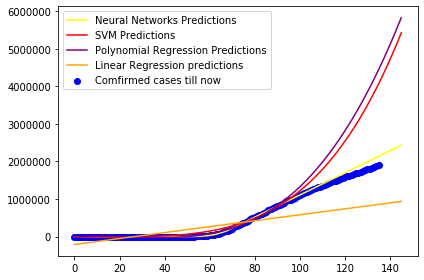

In [15]:
#plt.cla()
plt.scatter(future_forcast[:-10], us_cases, c = 'blue')
# plot the NN prediction
plt.plot(future_forcast, nn_future_pred, c = 'yellow')
# plot the SVM prediction
plt.plot(future_forcast, svm_future_pred, c = 'red')
# plot the polynomial prediction
plt.plot(future_forcast, poly_future_pred, c = 'purple')
#plot the linear regression prediction
plt.plot(future_forcast, linear_future_pred, c = 'orange')
plt.legend(['Neural Networks Predictions', 'SVM Predictions', 'Polynomial Regression Predictions', 'Linear Regression predictions','Comfirmed cases till now'])

Conclusions:

In the training data fitting, the performance order is: neural network > polynomial regression > SVM > linear regression
In the testing data fitting, the performance order is: neural network > SVM > polynomial regression > linear regression
The linear regression predicts the number lower than the factual value, however, SVM and the polynomial regression predict much higher than the factual value.
The neural network greatly fits the model and makes the best predictions.